In [105]:
import numpy as np
import regex as re
import pandas as pd
import gc
import logging
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import string
import nltk as nlp
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec, KeyedVectors
#from gensim.test.utils import common_texts
#from matplotlib.pyplot as plt
#from collections import Counter #like map but worse cuz it senses only the tally --> not for computation :(
from tensorflow.python.client import device_lib
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, SimpleRNN
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import seaborn as sns

In [2]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 916339987779280946
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3156659406
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11513661521220419997
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
print(tf.test.is_built_with_cuda())

True


#### LOADING IMDB DATASET

In [4]:
dataframe = pd.read_csv(r'..\\IMDB Dataset.csv')

In [5]:
dataframe.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
dataframe.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,negative
freq,5,25000


In [7]:
np.shape(dataframe)

(50000, 2)

In [8]:
dataframe['sentiment'] = dataframe['sentiment'].replace('positive', 1)
dataframe['sentiment'] = dataframe['sentiment'].replace('negative', 0)
dataframe.head()
#in case of non-binary classes it makes more sense to use label encoder rather than replace

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


#### CHECK FOR NULLS AND DUPLICATES

In [9]:
dataframe.isnull().sum()

review       0
sentiment    0
dtype: int64

In [10]:
dataframe.duplicated().sum()

418

In [11]:
dataframe.drop_duplicates(subset='review', keep='first', inplace=True)

In [12]:
np.shape(dataframe)

(49582, 2)

In [13]:
dataframe.duplicated().sum()

0

In [14]:
dataframe.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


#### split into test and train samples

In [15]:
train, test = train_test_split(dataframe, test_size = 0.3, random_state = 156, shuffle=True)

In [16]:
train.head()

,review,sentiment
3298,This movie is about a group of people who are ...,0
20811,This was a less than exciting short film I saw...,0
49519,"<br /><br />Crackerjack, starring Mick Malloy ...",1
32422,Why do I watch movies like this ? - other than...,0
49066,"""Why did they make them so big? Why didn't the...",1


In [17]:
test.head()

,review,sentiment
10310,"Chaplin was great a silent comedian, but many ...",0
20472,This has got to be one of Australia's best pro...,1
31604,A surprising misfire from the usually reliable...,0
26404,Why do people bitch about this movie and not a...,1
30664,"Criticism of the film EVENING, based on the no...",1


In [18]:
del dataframe

In [19]:
X_train = train['review'].values
y_train = train['sentiment'].values
X_test = test['review'].values
y_test = test['sentiment'].values

In [20]:
del train, test

In [21]:
gc.collect()

0

#### REMOVING NON-WORD CHARACTERS FROM THE DATASET

In [22]:
def preprocess(text, pattern):
    if pattern=='[.]+':
        text = re.sub(pattern, '. ', text)
    elif pattern =="[']":
        text =  re.sub(pattern, ' ', text)
    else:
        text = re.sub(pattern, '', text)
    #print(text, '\n')
    return text

In [23]:
X_train = np.vectorize(preprocess)(X_train, '<[^>]*>') #remove markup
#print(dataframe.loc[0, 'review'])
#dataframe.head()
X_test = np.vectorize(preprocess)(X_test, '<[^>]*>') #remove markup

In [24]:
X_train = np.vectorize(preprocess)(X_train, '[.]+') #remove ... and replace with .
#print(dataframe.loc[0, 'review'])
#dataframe.head()
X_test = np.vectorize(preprocess)(X_test, '[.]+') #remove ... and replace with .

In [25]:
X_train = np.vectorize(preprocess)(X_train, '[0-9]+') #remove numbers and replace with none
#print(dataframe.loc[0, 'review'])
#dataframe.head()
X_test = np.vectorize(preprocess)(X_test, '[0-9]+') #remove numbers and replace with none
#print(X_train)

In [26]:
X_train = np.vectorize(preprocess)(X_train, "[']") #remove ' and replace with 
#print(dataframe.loc[0, 'review'])
#train.head()
X_test = np.vectorize(preprocess)(X_test, "[']") #remove ' and replace with 

In [27]:
gc.collect()

0

In [28]:
X_train = np.vectorize(preprocess)(X_train, '[^\w\s]*') #remove everything that's not word space
# ' is left to handle contractions
#print(dataframe.loc[0, 'review'])
X_test = np.vectorize(preprocess)(X_test, '[^\w\s]*') #remove everything that's not word space or '

In [29]:
X_train[0]

'This movie is about a group of people who are infected by a powerful manmade virus  They are pursued by government men into the desert The premise of the film is quite interesting but is hampered by the fact that the delivery is extremely boring  At no point does the film engage with the viewer on any level  Granted the miniscule budget is a problem but is not the reason for the film s failure  Much more at fault is the very pofaced delivery  There is a great deal of narration but unfortunately the narrator has an annoyingly overdramatic voice  Very little seems to happen to these people and well before the end you will be rooting for the government men  the sooner they kill the protagonists the sooner the movie will end  A much better title for this film would have been Four People Run About In The Desert With Some Stock Footage Of A Helicopter  Overall very tedious '

In [30]:
X_train = [sentence.lower() for sentence in X_train] #make it lower
print(X_train[0])
X_test = [sentence.lower() for sentence in X_test] #make it lower
#print(dataframe.loc[0, 'review'])
#X_test = X_test.str.lower()#make it lower
#test.head()

this movie is about a group of people who are infected by a powerful manmade virus  they are pursued by government men into the desert the premise of the film is quite interesting but is hampered by the fact that the delivery is extremely boring  at no point does the film engage with the viewer on any level  granted the miniscule budget is a problem but is not the reason for the film s failure  much more at fault is the very pofaced delivery  there is a great deal of narration but unfortunately the narrator has an annoyingly overdramatic voice  very little seems to happen to these people and well before the end you will be rooting for the government men  the sooner they kill the protagonists the sooner the movie will end  a much better title for this film would have been four people run about in the desert with some stock footage of a helicopter  overall very tedious 


#### DOES IT MAKE SENSE TO REMOVE SOME WORDS TO REDUCE COMPUTATION?

In [31]:
count = CountVectorizer()
bag = count.fit_transform(X_train)
len(count.vocabulary_)

121963

#### Got over 2 Lakh words --> it makes sense to remove some words like articles and prepositions out
#### Better to remove stop words first (Why? --> documentation wip)

In [32]:
#something with tfidf
#question: does it make sense to do tfidf first and then remove stop words using the nltk corpus or 
#remove stop words using the corpus first then perform tfidf next

In [33]:
nlp.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rps24\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [34]:
stop = set(stopwords.words('english')) #set makes serach O(1)
#originally stopwords.words('english') yields a list
#print(stop)

In [35]:
ps  = PorterStemmer()

In [36]:
def remove_stopwords_and_stem(text):
    text_ = word_tokenize(text)
    tokens = []
    #print(text_)
    for word in text_:
        if word not in stop:
            tokens.append(ps.stem(word))
    #return lemmatization(tokens)
    #print(tokens)
    text = ' '.join(tokens) #send only tokens sent as a joined sentence
    return text 

In [37]:
X_train = np.vectorize(remove_stopwords_and_stem)(X_train)
X_test = np.vectorize(remove_stopwords_and_stem)(X_test)
print(X_train[0])

movi group peopl infect power manmad viru pursu govern men desert premis film quit interest hamper fact deliveri extrem bore point film engag viewer level grant miniscul budget problem reason film failur much fault pofac deliveri great deal narrat unfortun narrat annoyingli overdramat voic littl seem happen peopl well end root govern men sooner kill protagonist sooner movi end much better titl film would four peopl run desert stock footag helicopt overal tediou


In [38]:
lemmatizer = WordNetLemmatizer()
nlp.download('wordnet')
reviews = []

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rps24\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [39]:
def lemmatization(text):
    text_ = word_tokenize(text)
    tokens = []
    for word in text_:
        tokens.append(lemmatizer.lemmatize(word))
    text = ' '.join(tokens)
    reviews.append(tokens)
    return text

In [40]:
X_train = np.vectorize(lemmatization)(X_train)
X_test = np.vectorize(lemmatization)(X_test)
print(X_train[0])

movi group peopl infect power manmad viru pursu govern men desert premis film quit interest hamper fact deliveri extrem bore point film engag viewer level grant miniscul budget problem reason film failur much fault pofac deliveri great deal narrat unfortun narrat annoyingli overdramat voic littl seem happen peopl well end root govern men sooner kill protagonist sooner movi end much better titl film would four peopl run desert stock footag helicopt overal tediou


#### word2vec

In [41]:
all_reviews = np.array(reviews)
del reviews

C:\Users\rps24\anaconda3\envs\senti-gpu\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [42]:
gc.collect()

0

In [43]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [44]:
word2vec_model = Word2Vec(all_reviews, window = 3, min_count = 1, sg = 2, size = 256, workers = 5) #sg --> skipgram
#workers --> number of threads in useb

2021-10-04 22:15:48,667 : INFO : collecting all words and their counts
2021-10-04 22:15:48,669 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-10-04 22:15:48,867 : INFO : PROGRESS: at sentence #10000, processed 1160527 words, keeping 46426 word types
2021-10-04 22:15:49,073 : INFO : PROGRESS: at sentence #20000, processed 2337204 words, keeping 68209 word types
2021-10-04 22:15:49,258 : INFO : PROGRESS: at sentence #30000, processed 3510222 words, keeping 86075 word types
2021-10-04 22:15:49,456 : INFO : PROGRESS: at sentence #40000, processed 4660315 words, keeping 102157 word types
2021-10-04 22:15:49,649 : INFO : collected 116586 word types from a corpus of 5783944 raw words and 49584 sentences
2021-10-04 22:15:49,650 : INFO : Loading a fresh vocabulary
2021-10-04 22:15:49,815 : INFO : effective_min_count=1 retains 116586 unique words (100% of original 116586, drops 0)
2021-10-04 22:15:49,816 : INFO : effective_min_count=1 leaves 5783944 word corpus (

2021-10-04 22:16:52,000 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-10-04 22:16:52,012 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-10-04 22:16:52,038 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-10-04 22:16:52,064 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-10-04 22:16:52,065 : INFO : EPOCH - 4 : training on 5783944 raw words (5463401 effective words) took 11.2s, 485801 effective words/s
2021-10-04 22:16:53,099 : INFO : EPOCH 5 - PROGRESS: at 8.77% examples, 465325 words/s, in_qsize 9, out_qsize 0
2021-10-04 22:16:54,105 : INFO : EPOCH 5 - PROGRESS: at 17.38% examples, 464652 words/s, in_qsize 9, out_qsize 0
2021-10-04 22:16:55,119 : INFO : EPOCH 5 - PROGRESS: at 26.46% examples, 472577 words/s, in_qsize 9, out_qsize 0
2021-10-04 22:16:56,143 : INFO : EPOCH 5 - PROGRESS: at 36.00% examples, 482237 words/s, in_qsize 9, out_qsize 0
2021-10-04 22:16:57,177 : INFO : EPOCH 5 - PROG

In [45]:
#need to save model here
word2vec_model.wv.save_word2vec_format('../word_embeddings.txt')

2021-10-04 22:17:03,354 : INFO : storing 116586x256 projection weights into ../word_embeddings.txt


In [44]:
word2vec_model = KeyedVectors.load_word2vec_format('../word_embeddings.txt', binary = False, unicode_errors = 'ignore')

2021-10-06 12:03:48,667 : INFO : loading projection weights from ../word_embeddings.txt
2021-10-06 12:04:19,790 : INFO : KeyedVectors lifecycle event {'msg': 'loaded (116586, 256) matrix of type float32 from ../word_embeddings.txt', 'binary': False, 'encoding': 'utf8', 'datetime': '2021-10-06T12:04:19.790818', 'gensim': '4.0.1', 'python': '3.6.13 |Anaconda, Inc.| (default, Mar 16 2021, 11:37:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'load_word2vec_format'}


In [45]:
word2vec_model.similarity('saw', 'may')

0.40047997

In [46]:
word2vec_model.similarity('saw', 'say')

0.4299609

In [47]:
word2vec_model.similarity('say', 'may')

0.46379727

In [48]:
word2vec_model.similarity('gangsta', 'latino')

0.68123794

In [49]:
len(word2vec_model.key_to_index)

116586

In [50]:
gc.collect()

0

#### load dictionary of word to vectors --> from gensim instance to dictionary

In [51]:
embedding = {}
with open('../word_embeddings.txt', encoding = 'utf-8') as f:
    #page = f.read()
    for line in f:
        record = line.split()
        #print(record[0])
        #word = record[0]
        embedding[record[0]] = np.asarray(record[1:])        

In [52]:
print(len(embedding))

116587


In [53]:
gc.collect()

0

#### CREATING TENSORS

In [80]:
token_tensor = Tokenizer()
token_tensor.fit_on_texts(all_reviews)
maxim = 0
for  review in all_reviews:
    maxim = max(maxim, len(review))
X_train_token = token_tensor.texts_to_sequences(X_train)
X_train_pad = pad_sequences(X_train_token, maxlen = maxim, padding='post')
X_test_token = token_tensor.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_token, maxlen = maxim, padding='post')

In [81]:
X_train_pad.shape

(34707, 1406)

In [82]:
y_train.shape

(34707,)

In [83]:
X_test_pad.shape

(14875, 1406)

In [84]:
y_test.shape

(14875,)

In [57]:
vocabulary = token_tensor.word_index

In [58]:
vocabulary_size = len(vocabulary) + 1
print(vocabulary_size)

116587


In [59]:
embed_matrix = np.zeros((vocabulary_size, 256))

In [60]:
for word, i in vocabulary.items():
    vector = embedding.get(word)
    if vector is not None:
        embed_matrix[i] = vector
#create a np array of all vector values

In [61]:
embed_matrix.shape

(116587, 256)

In [62]:
3input_shape = X_train_pad.shape
print(input_shape)

(34707, 1406)


#### simple rnn

In [85]:
simple_rnn = Sequential()
embedding_layer = Embedding(vocabulary_size, 
                            256, 
                            embeddings_initializer = Constant(embed_matrix), 
                            input_length = maxim, 
                            trainable = False)
simple_rnn.add(embedding_layer)
simple_rnn.add(SimpleRNN(units = 32, input_shape = input_shape, dropout = 0.2, activation = 'relu', recurrent_dropout = 0.2))
simple_rnn.add(Dense(units = 16, activation = 'relu'))
simple_rnn.add(Dense(units=1, activation='softmax'))

In [86]:
simple_rnn.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

In [87]:
simple_rnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1406, 256)         29846272  
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 32)                9248      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 29,856,065
Trainable params: 9,793
Non-trainable params: 29,846,272
_________________________________________________________________


In [95]:
simple_rnn_history = simple_rnn.fit(X_train_pad, 
                                    y_train, 
                                    batch_size=128, 
                                    epochs=25, 
                                    validation_data=(X_test_pad, y_test), 
                                    verbose=2)

Train on 34707 samples, validate on 14875 samples
Epoch 1/25
 - 248s - loss: 7.9200 - acc: 0.5032 - val_loss: 7.9910 - val_acc: 0.4988
Epoch 2/25
 - 259s - loss: 7.9200 - acc: 0.5032 - val_loss: 7.9910 - val_acc: 0.4988
Epoch 3/25
 - 292s - loss: 7.9200 - acc: 0.5032 - val_loss: 7.9910 - val_acc: 0.4988
Epoch 4/25
 - 382s - loss: 7.9200 - acc: 0.5032 - val_loss: 7.9910 - val_acc: 0.4988
Epoch 5/25
 - 381s - loss: 7.9200 - acc: 0.5032 - val_loss: 7.9910 - val_acc: 0.4988
Epoch 6/25
 - 385s - loss: 7.9200 - acc: 0.5032 - val_loss: 7.9910 - val_acc: 0.4988
Epoch 7/25
 - 380s - loss: 7.9200 - acc: 0.5032 - val_loss: 7.9910 - val_acc: 0.4988
Epoch 8/25
 - 363s - loss: 7.9200 - acc: 0.5032 - val_loss: 7.9910 - val_acc: 0.4988
Epoch 9/25
 - 250s - loss: 7.9200 - acc: 0.5032 - val_loss: 7.9910 - val_acc: 0.4988
Epoch 10/25
 - 253s - loss: 7.9200 - acc: 0.5032 - val_loss: 7.9910 - val_acc: 0.4988
Epoch 11/25
 - 253s - loss: 7.9200 - acc: 0.5032 - val_loss: 7.9910 - val_acc: 0.4988
Epoch 12/25
 

In [97]:
simple_rnn.save('..\\simple_rnn.h5')

MemoryError: 

In [ ]:
del simple_rnn
gc.collect()

In [ ]:
simple_rnn = load_model('..\simple_rnn.h5')

#### metrics

In [ ]:
#predict with validation set 
#do everything with validation set

In [101]:
y_pred = simple_rnn.predict(X_test_pad)

In [103]:
y_pred

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

#### confusion matrix

In [106]:
cf_matrix = confusion_matrix(y_test, y_pred)  
print(cf_matrix)

[[   0 7456]
 [   0 7419]]


<AxesSubplot:>

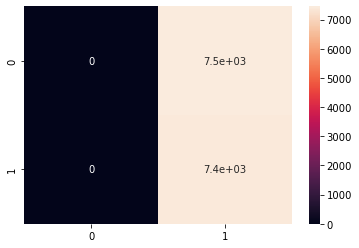

In [107]:
sns.heatmap(cf_matrix, annot=True)

#### classification report

In [108]:
report = classification_report(y_test, y_pred)
print('Report: \n',report)

Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      7456
           1       0.50      1.00      0.67      7419

    accuracy                           0.50     14875
   macro avg       0.25      0.50      0.33     14875
weighted avg       0.25      0.50      0.33     14875



C:\Users\rps24\anaconda3\envs\senti-gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rps24\anaconda3\envs\senti-gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rps24\anaconda3\envs\senti-gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
